In [2]:
import os
from PIL import Image
import util.image_import as ii
from glob import glob
import numpy as np
import tensorflow as tf
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from keras import backend as K
import matplotlib.pyplot as plt
from keras.applications import mobilenet
from keras.layers import Dense, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.models import Model, Sequential
from keras import models
from keras import layers
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam, RMSprop, SGD
from util.plots import plot_history
%matplotlib inline
%load_ext autoreload
%autoreload 2

### Subtracting mean and normalizing to save pictures

In [3]:
cfg = K.tf.ConfigProto() # Config to dynamically add memory
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))# set this TensorFlow session as the default session for Keras.

In [15]:
# Importing the images
train_pot = glob(os.path.join("../dataset2/res_still/train/potato", "*.jpg"))
train_cat = glob(os.path.join("../dataset2/res_still/train/catfood", "*.jpg"))
train_tab = glob(os.path.join("../dataset2/res_still/train/table", "*.jpg"))
val_pot   = glob(os.path.join("../dataset2/res_still/valid/potato", "*.jpg"))
val_cat   = glob(os.path.join("../dataset2/res_still/valid/catfood", "*.jpg"))
val_tab   = glob(os.path.join("../dataset2/res_still/valid/table", "*.jpg"))
test_pot  = glob(os.path.join("../dataset2/res_still/test/potato", "*.jpg"))
test_cat  = glob(os.path.join("../dataset2/res_still/test/catfood", "*.jpg"))
test_tab  = glob(os.path.join("../dataset2/res_still/test/table", "*.jpg"))

X_train, y_train = ii.images_to_numpy(train_pot, train_cat, train_tab)
X_val, y_val = ii.images_to_numpy(val_pot, val_cat, val_tab)
X_test, y_test = ii.images_to_numpy(test_pot, test_cat, test_tab)

batch_size = 32
num_classes = 3

# Making datagen for training with normilization, center, and dataugmentation
train_datagen = ImageDataGenerator(
        featurewise_center=True,
        #featurewise_std_normalization=True
        rescale=1./255,
        rotation_range=10,
        vertical_flip=True,
        horizontal_flip=True,
        brightness_range=(0.65, 1.35)
)

# Making datagen for validation and test with normilization
valid_datagen = ImageDataGenerator(
        featurewise_center=True, 
        #featurewise_std_normalization=True
        rescale=1./255
)


X_train = X_train.astype(float)
X_val = X_val.astype(float)
X_test = X_test.astype(float)

y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)

# Required for featurewise normalization
train_datagen.fit(X_train/255.)
valid_datagen.fit(X_train/255.)

train_generator = train_datagen.flow(X_train,
                                     y_train,
                                     batch_size=batch_size, shuffle=True)

validation_generator = valid_datagen.flow(X_val,
                                     y_val,
                                     batch_size=batch_size, shuffle=True)

test_generator = valid_datagen.flow(X_test,
                                     y_test,
                                     batch_size=80, shuffle=True)


## Optimized model

In [5]:
model = Sequential()
model.add(Flatten(input_shape=(224,224,3)))
# kernel_regularizer: Regularizer function applied to the kernel weights matrix (see regularizer).
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(3))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=1e-4), # lr=0.0001
              metrics=['accuracy'])

model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               77070848  
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 1539      
_________________________________________________________________
activation_2 (Activation)    (None, 3)                 0         
Total params: 77,072,387
Trainable params: 77,072,387
Non-trainable params: 0
_________________________________________________________________


In [6]:
history = model.fit_generator(
            train_generator,
            steps_per_epoch=573 // batch_size,
            epochs=100,
            validation_data=validation_generator,
            validation_steps=160 // batch_size)


Epoch 1/100
17/17 [==============================] - 6s 333ms/step - loss: 4.5704 - acc: 0.4111 - val_loss: 4.6066 - val_acc: 0.4062
Epoch 2/100
17/17 [==============================] - 5s 303ms/step - loss: 4.5659 - acc: 0.4626 - val_loss: 1.8452 - val_acc: 0.5125
Epoch 3/100
17/17 [==============================] - 5s 305ms/step - loss: 2.7382 - acc: 0.4926 - val_loss: 1.3987 - val_acc: 0.7063
Epoch 4/100
17/17 [==============================] - 5s 304ms/step - loss: 2.0770 - acc: 0.5312 - val_loss: 1.3386 - val_acc: 0.4938
Epoch 5/100
17/17 [==============================] - 5s 305ms/step - loss: 1.8665 - acc: 0.6255 - val_loss: 0.9602 - val_acc: 0.6125
Epoch 6/100
17/17 [==============================] - 5s 318ms/step - loss: 1.7904 - acc: 0.6342 - val_loss: 0.5311 - val_acc: 0.7812
Epoch 7/100
17/17 [==============================] - 6s 338ms/step - loss: 1.1082 - acc: 0.6643 - val_loss: 0.4746 - val_acc: 0.7937
Epoch 8/100
17/17 [==============================] - 6s 341ms/step - 

17/17 [==============================] - 8s 447ms/step - loss: 0.5843 - acc: 0.8658 - val_loss: 0.1430 - val_acc: 0.9437
Epoch 63/100
17/17 [==============================] - 7s 426ms/step - loss: 0.3760 - acc: 0.8829 - val_loss: 0.1276 - val_acc: 0.9500
Epoch 64/100
17/17 [==============================] - 7s 403ms/step - loss: 0.4592 - acc: 0.8621 - val_loss: 0.1154 - val_acc: 0.9625
Epoch 65/100
17/17 [==============================] - 7s 392ms/step - loss: 0.2124 - acc: 0.9301 - val_loss: 0.1045 - val_acc: 0.9563
Epoch 66/100
17/17 [==============================] - 7s 387ms/step - loss: 0.2968 - acc: 0.9073 - val_loss: 0.1029 - val_acc: 0.9625
Epoch 67/100
17/17 [==============================] - 7s 389ms/step - loss: 0.1378 - acc: 0.9559 - val_loss: 0.1321 - val_acc: 0.9375
Epoch 68/100
17/17 [==============================] - 7s 383ms/step - loss: 0.1568 - acc: 0.9441 - val_loss: 0.0471 - val_acc: 0.9875
Epoch 69/100
17/17 [==============================] - 7s 404ms/step - loss:

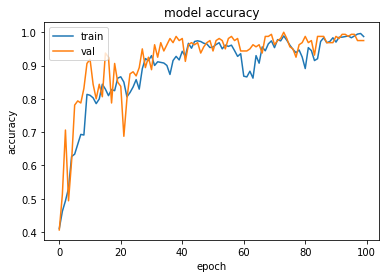

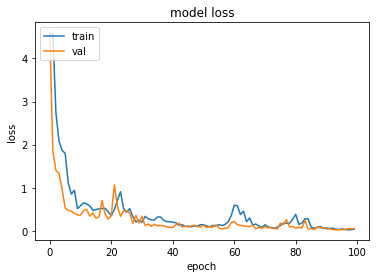

In [19]:
plot_history(history, save=True, path='nets/feedforward/', name='plot_full')

In [16]:
imgs, labels = next(test_generator)

#ynew = model.predict(imgs)
#results[(lr, lrd, rs, hl)] = (y_train_acc, y_pred_acc)

model.evaluate(imgs,labels, batch_size=80)

80/80 [==============================] - 0s 635us/step


[0.08938185125589371, 0.9750000238418579]

In [ ]:
imgs, labels = next(validation_generator)
model.predict(imgs)
#print(imgs)


## Hyperparameter optimization

In [17]:
# Only work with tensorflow=1.8 and keras=2.1.6 because of the memory allocation

# Hyperparameters
learning_rates = [1e-3, 1e-4, 1e-5];
hidden_size = [64, 128, 256, 512];
history = []
result = None
results = []

for lr in learning_rates:
    for hs in hidden_size:
        # GPU memory allocation
        cfg = K.tf.ConfigProto() # Create setup file for keras tensorflow
        cfg.gpu_options.allow_growth = True # Setting setup file with dynamically adding gpu memory
        K.set_session(K.tf.Session(config=cfg)) # Setting session to use setup file
        sess = tf.Session() 
        K.set_session(sess)# set this TensorFlow session as the default session for Keras.
        
        # Defining the model:
        model = Sequential()
        model.add(Flatten(input_shape=(224,224,3)))
        model.add(Dense(hs))
        model.add(Activation('relu'))
        model.add(Dense(3))
        model.add(Activation('softmax'))
        model.compile(loss='categorical_crossentropy',
                      optimizer=Adam(lr=lr),
                      metrics=['accuracy'])
        
        
        # Running the model:
        temp = (model.fit_generator(
            train_generator,
            steps_per_epoch=384 // batch_size,
            epochs=100,
            validation_data=validation_generator,
            validation_steps=100 // batch_size))
        
        # Saving the results
        history.append(temp)
        train_acc = temp.history['acc'].pop()
        val_acc = temp.history['val_acc'].pop()
        result = (lr, hs, train_acc, val_acc)
        results.append(result)
        K.clear_session() # Clearing the session to clear out gpu memory
        

Epoch 1/1
12/12 [==============================] - 3s 284ms/step - loss: 9.3105 - acc: 0.3587 - val_loss: 8.9185 - val_acc: 0.3438
Epoch 1/1
12/12 [==============================] - 3s 287ms/step - loss: 8.9762 - acc: 0.3875 - val_loss: 9.4022 - val_acc: 0.4167


______________________________________________________________________
lr 1.000000e-03 hs 2 train accuracy: 0.360563 val accuracy: 0.343750


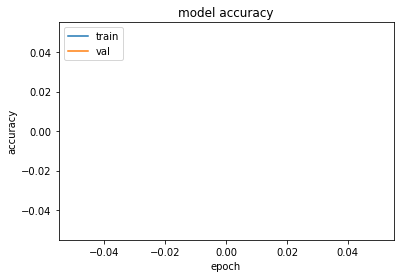

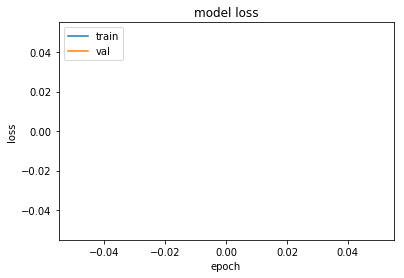

______________________________________________________________________
lr 1.000000e-03 hs 3 train accuracy: 0.391549 val accuracy: 0.416667


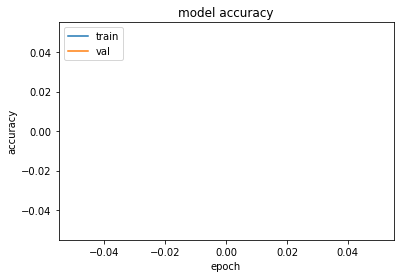

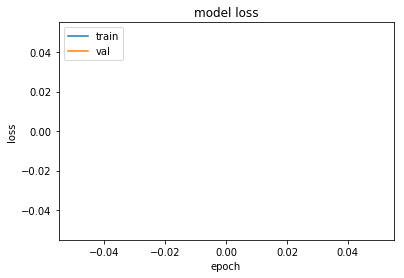

In [19]:
for index, h in enumerate(history):
    print("______________________________________________________________________")
    print('lr %e hs %i train accuracy: %f val accuracy: %f' % results[index])         
    plot_history(h, mean_N=3)


In [ ]:
model = test_model()
model.fit_generator(
            train_generator,
            steps_per_epoch=384 // batch_size,
            epochs=50,
            validation_data=validation_generator,
            validation_steps=100 // batch_size)
model.save(tmp_model_name)
del model
K.clear_session()
model = load_model(tmp_model_name)